# <b>Module 3 - Downstream Analysis and Visualization</b>
--------------------------------------------

## Overview
In this module, we will explore downstream analyses and visualization techniques for MeRIP-seq data, focusing on differential methylation and gene expression data. This includes interpreting methylation patterns, functional enrichment, and integrating RNA methylation with gene expression to gain insights into condition-specific changes in samples from different conditions. The module will cover essential steps such as package installation, data preparation, meta-gene and volcano plot generation, functional enrichment analysis, and RNA methylation and gene expression integration.

## Learning Objectives
+ **Learning Objective 1**: Understand the processes of downstream analysis and visualization for MeRIP-seq data, including differential methylation and gene expression analysis.
+ **Learning Objective 2**: Develop practical skills in generating key visualizations:
    - **2.1**: Create volcano plots to visualize significant differential methylation and gene expression changes.
    - **2.2**: Generate meta-gene plots to illustrate methylation distribution across gene features.
+ **Learning Objective 3**: Perform functional enrichment analysis to interpret the biological significance of differentially methylated or expressed genes.
+ **Learning Objective 4**: Integrate differential RNA methylation and gene expression data to identify genes with both methylation and expression changes, and visualize these relationships.


## Prerequisites
All the data needed in this submodule will be downloaded from cloud storage (AWS S3) or directly from online resources. 

## Outline
1. **Getting started**
     - Install packages
     - Set up environment, establishing input and output directories.
     - Download data files.
2. **RNA methylation data exploration and visualization**
    - Volcano plot
    - Meta-Gene plot
3. **Functional enrichment analysis**
    - Gene Ontology (GO) Enrichment Analysis
    - KEGG pathway Enrichment analysis
4. **Integration of RNA Methylation and Gene Expression** 
    - Extract gene expression data from Input samples
    - Differential gene expression analysis (DESeq2)
    - Integrate gene expression and RNA methylation
    

----
## <b>1. Get Started</b>


### 1.1 Install packages <mark style="background-color:AntiqueWhite;">(⏰ ~40 minites)</mark>

In [ ]:
start_time <- Sys.time()
# Ensure BiocManager and devtools are installed
if (!require("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
    message(" --- Installation of BiocManager is done. ---")
}

if (!require("devtools", quietly = TRUE)) {
    install.packages("devtools")
    message(" --- Installation of devtools is done. ---")
}

# Function to install packages if they are not already installed
install_if_missing <- function(packages, source = "CRAN") {
    missing_packages <- packages[!packages %in% installed.packages()[, "Package"]]
    if (length(missing_packages) > 0) {
        if (source == "Bioconductor") {
            BiocManager::install(missing_packages)
        } else if (source == "GitHub") {
            sapply(missing_packages, devtools::install_github)
        } else {
            install.packages(missing_packages)
        }
        message(" --- Installation of ", paste(missing_packages, collapse = ", "), " is done. ---")
    } else {
        message(" --- All specified packages are already installed. ---")
    }
}

# CRAN packages
cran_packages <- c("data.table","R.util","Rcpp", "ggplot2", "doParallel", "foreach", "gplots", "RColorBrewer", "RcppArmadillo", "BH")
install_if_missing(cran_packages)

# Bioconductor packages
bioc_packages <- c("Rsamtools", "GenomicFeatures", "DESeq2", "qvalue", "txdbmaker","BSgenome.Hsapiens.UCSC.hg38",
                   "Guitar","GenomicRanges","EnhancedVolcano", "clusterProfiler", "org.Hs.eg.db") # "Guitar", "clusterProfiler", "org.Hs.eg.db",
install_if_missing(bioc_packages, source = "Bioconductor")
# Bioconductor packages (needed in section 5)
#bioc_packages2 <- c("GenomicRanges", "ChIPpeakAnno", "VennDiagram", "rtracklayer", "ggplot2")
#install_if_missing(bioc_packages2, source = "Bioconductor")

# GitHub packages
#github_packages <- c("scottzijiezhang/MeRIPtools")
#install_if_missing(github_packages, source = "GitHub")
devtools::install_github("scottzijiezhang/MeRIPtools",build_vignettes=F)

end_time <- Sys.time()

# Calculate and print the duration
duration <- end_time - start_time
print(paste("Time taken:", duration))

### 1.2 Setting up directory structures
Establishing input and output directories

In [2]:
if (!file.exists("Tutorial_3")){
    dir.create(file.path("Tutorial_3"))
    #dir.create(file.path("Tutorial_3/bam"))
    #dir.create(file.path("Tutorial_3/RADAR"))
}
setwd(file.path("Tutorial_3"))
getwd()

[1] "/home/ec2-user/SageMaker/NIGMS-Sandbox-Repository-MeRIP-UH/Tutorial_3"

### 1.3 Download full dataset (processed) from GEO database

In [3]:
# RADAR processed data
radar_diff_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE119168&format=file&file=GSE119168%5FDiff%5Fpeaks%5FageCov%2Exls%2Egz"
download.file(radar_diff_url, "GSE119168_Diff_peaks_ageCov.xls.gz") 
radar_readcounts_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE119168&format=file&file=GSE119168%5FreadCounts%2Etsv%2Egz"
download.file(radar_readcounts_url, "GSE119168_readCounts.tsv.gz")

# NCBI-generated RNA-seq raw counts matrix
rnaseq_raw_count_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE119168&format=file&file=GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz"
download.file(rnaseq_raw_count_url, "GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz")

#### Load full dataset differential methylation data

In [4]:
library("data.table")
Diff_peaks_cov <- fread("GSE119168_Diff_peaks_ageCov.xls.gz")
head(Diff_peaks_cov)

chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
chr1,74571852,74571901,ERICH3,0,-,74571852,74571901,0,1,50,0,-5.149990,5.061621e-07
chr1,186308519,186308568,PRG4,0,+,186308519,186308568,0,1,50,0,4.988854,2.026962e-05
chr3,23203391,23208716,UBE2E2,0,+,23203391,23208716,0,2,"74,25","0,5301",4.569350,1.757806e-08
chr1,186308669,186308718,PRG4,0,+,186308669,186308718,0,1,50,0,4.445620,6.393407e-04
chr1,186307919,186307968,PRG4,0,+,186307919,186307968,0,1,50,0,4.421436,4.582737e-04
chr3,190388120,190388169,CLDN16,0,+,190388120,190388169,0,1,50,0,4.396009,3.941285e-05


**Volcano plot** is a popular visualization tool for displaying differentially expressed genes or features in a dataset. It plots log2 fold changes (showing the magnitude of change) on the x-axis and -log10 p-values (indicating statistical significance) on the y-axis. Genes with high fold changes and high significance appear at the plot’s corners, making it easy to identify the most strongly differentially expressed genes. 

Here is the volcano plot of the RADAR processed differentially methylated genes in the example dataset. Since all the genes/features included in the files are differentially methylated (pre-filtered already), the cutoffs (using default settings of <code>EnhanceVolcano</code>) of the pvalue in the volcano plot is 1e-06 and log2 fold change cutoff is 2, to show the most significant genes that are methylated.

Loading required package: ggplot2

Loading required package: ggrepel

Warning message:
“ggrepel: 137 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


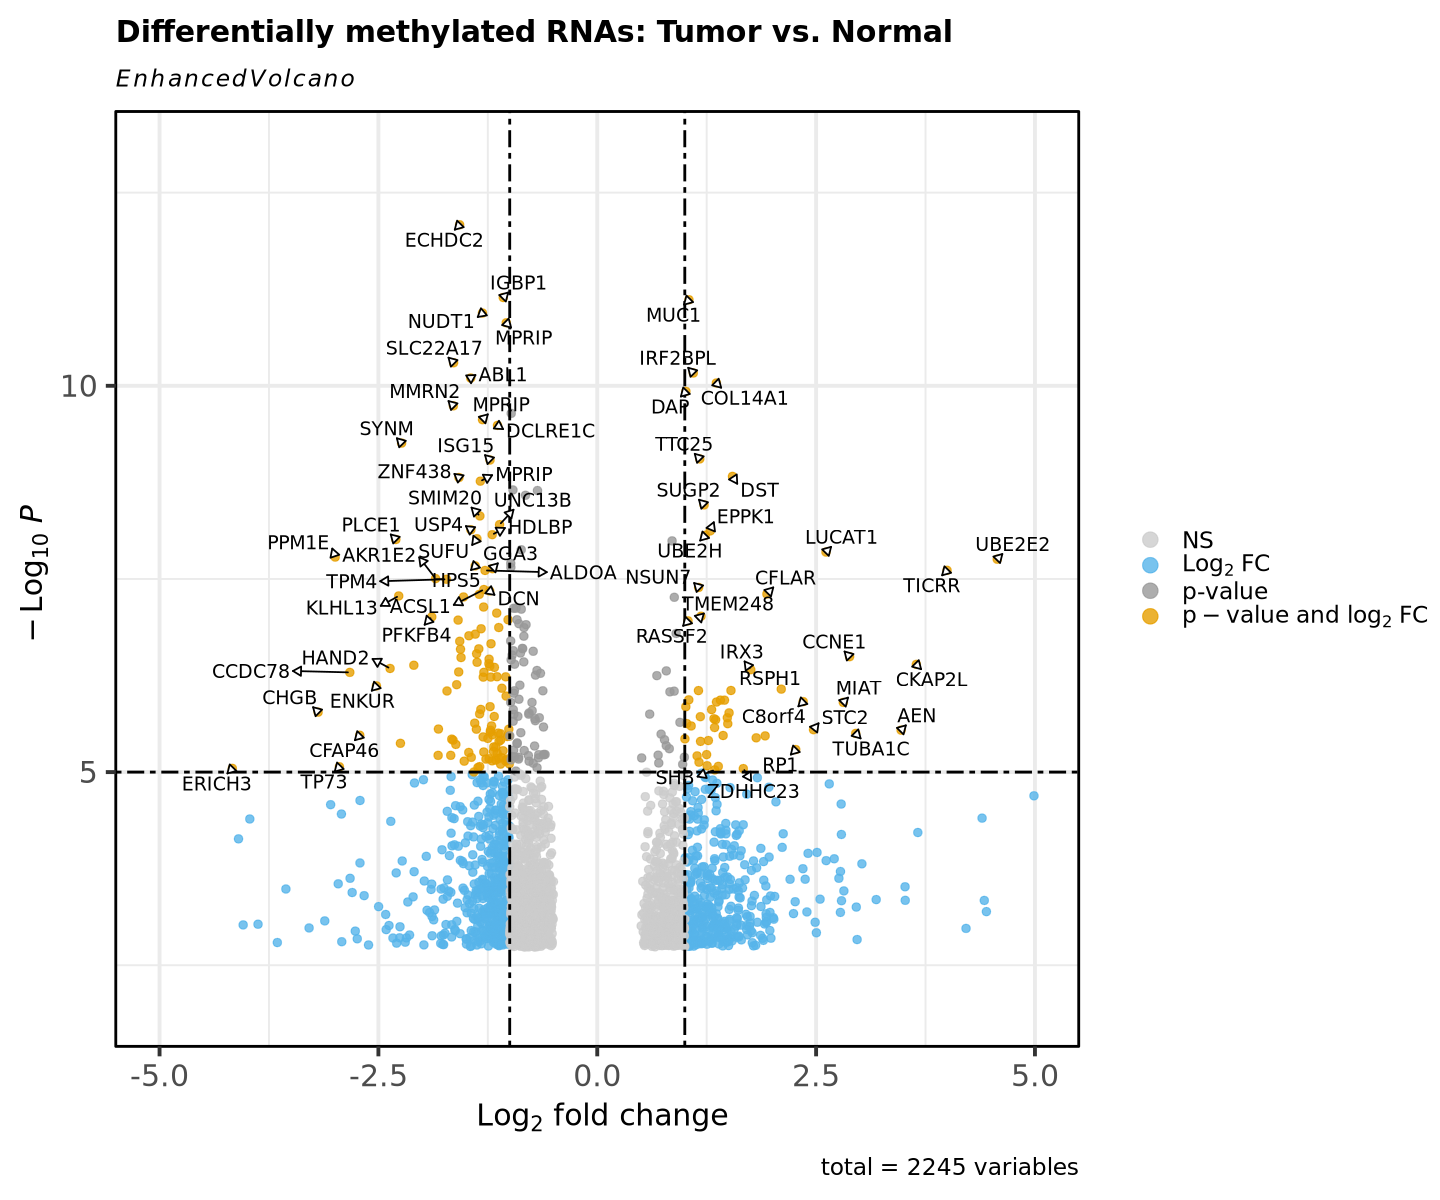

In [5]:
library("EnhancedVolcano")
options(repr.plot.width=12, repr.plot.height=10)
EnhancedVolcano(Diff_peaks_cov,
                title = "Differentially methylated RNAs: Tumor vs. Normal",
                lab = Diff_peaks_cov$name,
                x = 'logFC',
                y = 'p_value',
                xlim=c(-5,5),
                ylim=c(2,13),
                xlab = bquote(~Log[2]~ 'fold change'),
                cutoffLineType = 'twodash',
                cutoffLineWidth = 0.8,
                pointSize = 2,
                col = c('#cccccc', '#56B4E9', '#999999', '#E69F00'),
                colAlpha = 4/5,
                labSize = 4,
                legendPosition = 'right',
                legendLabSize = 14,
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.5,
                colConnectors = 'black',
                border = "full")

#### Load full dataset read counts data (bins) by RADAR

In [6]:
readcounts <- fread("GSE119168_readCounts.tsv.gz")
readcounts <- data.frame(readcounts,row.names=1)
head(readcounts)

Warning message in fread("GSE119168_readCounts.tsv.gz"):
“Detected 26 column names but the data has 27 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,OvCa1850.input,OvCa1917.input,OvCa2005.input,OvCa2013.input,OvCa2053.input,OvCa2064.input,OvCa2072.input,OvCa2186.input,OvCa2221.input,OvCa2261.input,⋯,OvCa2013.IP,OvCa2053.IP,OvCa2064.IP,OvCa2072.IP,OvCa2186.IP,OvCa2221.IP,OvCa2261.IP,OvCa2270.IP,OvCa2343.IP,OvCa2380.IP
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
"A1BG,25",0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
"A1BG,74",0,0,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,0
"A1BG,123",2,1,7,6,3,6,1,8,1,2,⋯,22,24,10,16,12,2,16,36,34,11
"A1BG,172",13,8,4,8,1,6,1,2,0,7,⋯,43,47,13,31,19,5,23,42,46,15
"A1BG,221",0,1,0,1,1,0,2,2,1,0,⋯,1,8,3,2,1,1,1,2,0,1
"A1BG,270",6,1,4,1,0,2,1,4,1,0,⋯,1,0,0,2,5,0,1,0,1,0


## <b>2. Meta-Gene plot</b>
A meta-gene plot is a visualization technique used in genomics to summarize read coverage or signal intensity across defined regions of interest, typically around gene bodies or specific genomic features, such as transcription start sites or methylation sites. In MeRIP-seq data analysis, a meta-gene plot helps illustrate the distribution of RNA methylation (like m6A) along genes, providing insights into where methylation commonly occurs, such as in the 5’ UTR, CDS, or 3’ UTR regions. This is helpful in MeRIP-seq studies because it allows researchers to observe patterns of methylation enrichment across genes, which can inform on potential regulatory roles of RNA modifications in gene expression. By comparing meta-gene plots across conditions, researchers can also identify shifts in methylation patterns, shedding light on condition-specific or disease-related changes in RNA methylation.

### 2.1 Download GTF annotation file
For the organism being analyzed, user need to provide an annotation file in gtf format to define the genomic coordinate of gene features. A good source to download those supporting files are <a href="https://support.illumina.com/sequencing/sequencing_software/igenome.html">iGenome</a>. Alternatively, the <a href="https://www.gencodegenes.org/">GENCODE</a> is also a good source for annotation if you are interested in human and mouse genome. In our example, we use the human annotated genome downloaded from GENCODE.

In [7]:
system("wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.basic.annotation.gtf.gz")
system("gzip -d gencode.v46.basic.annotation.gtf.gz")

### 2.2 Generate meta-gene plot <mark style="background-color:AntiqueWhite;">(⏰ ~5 minites)</mark>
The <code>plotMetaGene</code> function in <code>MeRIPtools</code> visualizes the distribution of methylated RNA peaks across defined genomic regions, such as gene bodies, in MeRIP-seq data. It is used to examine differentially methylated peaks across conditions by plotting read density along key regions, like 5’ or 3’ UTRs. The function can display methylation patterns for both mRNA and lncRNA transcripts, enabling comparisons between them. This distinction is useful as mRNA methylation often influences translation and stability, while lncRNA methylation may affect structure and molecular interactions.

<img src="images/3-metaGeneplot.png" width="600" />

In [ ]:
library("MeRIPtools")
library(ggsci)
options(repr.plot.width=14, repr.plot.height=6)
plotMetaGene(Diff_peaks_cov,"gencode.v46.basic.annotation.gtf")

## <b>3. Functional enrichment analysis</b>
There are two major types of enrichment analysis:
1. **Over Representation Analysis (ORA)** (Boyle et al. 2004) is a widely used approach to determine whether known biological functions or processes are over-represented (= enriched) in an experimentally-derived gene list, e.g. a list of differentially expressed genes (DEGs). This approach will find genes where the difference is large and will fail where the difference is small, but evidenced in coordinated way in a set of related genes.
2. **Gene Set Enrichment Analysis (GSEA)** (Subramanian et al. 2005) aggregates the per gene statistics across genes within a gene set, therefore making it possible to detect situations where all genes in a predefined set change in a small but coordinated way. This is important since it is likely that many relevant phenotypic differences are manifested by small but consistent changes in a set of genes. Genes are ranked based on their phenotypes. Given apriori defined set of gene S (e.g., genes sharing the same DO category), the goal of GSEA is to determine whether the members of S are randomly distributed throughout the ranked gene list (L) or primarily found at the top or bottom.

Here, we use **ORA** to showcase the functional enrichment analysis. To begin with, load required packages and rename the genes:

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
eg_diffPeak_cov <- bitr(unique(Diff_peaks_cov$name), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")

### 3.1 GO enrichment analysis 
Gene Ontology (GO) defines concepts/classes used to describe gene function, and relationships between these concepts. It classifies functions along three aspects:
- MF (Molecular Function): molecular activities of gene products
- CC (Cellular Component): where gene products are active
- BP (Biological Process): pathways and larger processes made up of the activities of multiple gene products

GO terms are organized in a directed acyclic graph, where edges between terms represent parent-child relationship.



In [10]:
library(clusterProfiler)
library(org.Hs.eg.db)
eg_diffPeak_cov <- bitr(unique(Diff_peaks_cov$name), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
ego_diffPeak_cov <- enrichGO(gene  = eg_diffPeak_cov$ENTREZID,
                #universe      = bitr(rownames(RADAR@geneSum), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
        readable      = TRUE)
head(ego_diffPeak_cov)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(unique(Diff_peaks_cov$name), fromType = "SYMBOL", toType = "ENTREZID", :
“6.34% of input gene IDs are fail to map...”


,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031589,GO:0031589,cell-substrate adhesion,66/1539,361/18986,0.1828255,2.255442,7.152637,2.868505e-10,1.643366e-06,1.386545e-06,L1CAM/WNT4/LDB1/LIMS1/TACSTD2/SVEP1/DLC1/ADAMTS9/TAOK2/BCL2/ABL1/FMN1/ITGA6/SPOCK1/CDH11/FLNA/PPFIA1/FBLN2/BCL6/MINK1/PTPRA/EMILIN1/CSF1/JUP/VEGFA/ECM2/PDPN/NF2/EPHB3/EFNA1/FBLN1/PEAK1/ITGA5/ITGB5/VWF/CRKL/FN1/STK4/PTEN/FZD7/ANTXR1/MKLN1/ROCK1/PTK2/MYADM/ADAM9/SDC4/DAPK3/TMEM8B/RCC2/BCAM/TIAM1/PARVA/CTNNB1/LAMB1/ROCK2/P4HB/GSK3B/NEDD9/DAB2/SLK/UTRN/CX3CL1/PIK3R1/LAMC1/VCAM1,66
GO:0002009,GO:0002009,morphogenesis of an epithelium,81/1539,500/18986,0.1620000,1.998526,6.720279,1.265122e-09,3.092938e-06,2.609580e-06,WNT4/HAND2/ALDH1A2/IRX3/STK3/ID4/MMRN2/TACSTD2/MTHFR/DLC1/PAX8/DNAAF1/RBPJ/BCL2/APAF1/ABL1/FMN1/LMO4/SEMA3C/COL4A1/NRARP/SUFU/FLNA/PAFAH1B1/BSG/FZD6/GLI2/MTSS1/SKI/ACTB/TBX3/RASIP1/TWIST1/TGM2/PBX1/MET/TRAF3IP1/INTU/TGFB1I1/FAT1/CSF1/HS3ST3A1/VEGFA/EPHA2/RBM15/PDPN/CELSR1/COL5A1/ITGA5/BBS5/ITGB5/ERBB4/STK4/PTEN/NKD1/GJA1/TIMELESS/HOXB4/CXCR4/BTBD7/PKD2/MYO9A/PDGFA/SOS1/SDC4/DLL4/HOXB7/MED1/RHOB/LIF/SFRP2/CTNNB1/ARHGAP12/ACVR1/NR3C1/CCM2/SPINT2/PFN1/EXT1/ST14/FEM1B,81
GO:0150115,GO:0150115,cell-substrate junction organization,29/1539,103/18986,0.2815534,3.473407,7.475545,1.619622e-09,3.092938e-06,2.609580e-06,WNT4/LDB1/DST/LIMS1/DLC1/TAOK2/BCL2/ABL1/FMN1/ITGA6/CDH11/PTPRA/VEGFA/PEAK1/ITGA5/PLEC/FN1/PTEN/ROCK1/PTK2/SDC4/ARF6/DAPK3/RCC2/ROCK2/SLK/IQSEC1/PIK3R1/LAMC1,29
GO:0002064,GO:0002064,epithelial cell development,45/1539,219/18986,0.2054795,2.534914,6.785361,4.992295e-09,7.150214e-06,6.032794e-06,BCL11B/RFX3/PDE4D/CCDC88C/S1PR2/TMOD1/CLDN5/FNDC3A/FLNA/FOXJ1/MYD88/RAP1A/HEG1/MET/PRDM1/FAT1/VEGFA/EPHA2/RILPL2/PALLD/SIPA1/PECAM1/PLEC/FOSL2/ATRX/AMOTL2/GJA1/CXCR4/ROCK1/MYADM/SIPA1L3/CLDN3/EXPH5/FLNB/MAGI1/ROCK2/GSK3B/CCM2/ARID4A/SPINT2/ASXL1/F11R/ST14/IQGAP1/FEM1B,45
GO:0003382,GO:0003382,epithelial cell morphogenesis,16/1539,37/18986,0.4324324,5.334738,7.838534,8.030087e-09,8.578236e-06,7.237648e-06,BCL11B/CCDC88C/HEG1/MET/FAT1/RILPL2/PALLD/SIPA1/AMOTL2/ROCK1/SIPA1L3/CLDN3/FLNB/MAGI1/SPINT2/ST14,16
GO:0010810,GO:0010810,regulation of cell-substrate adhesion,45/1539,223/18986,0.2017937,2.489445,6.644923,8.984014e-09,8.578236e-06,7.237648e-06,WNT4/LDB1/LIMS1/TACSTD2/DLC1/BCL2/ABL1/FMN1/ITGA6/SPOCK1/FLNA/FBLN2/BCL6/MINK1/PTPRA/EMILIN1/CSF1/JUP/VEGFA/ECM2/PDPN/NF2/FBLN1/PEAK1/ITGA5/CRKL/FN1/STK4/PTEN/FZD7/ROCK1/PTK2/MYADM/SDC4/DAPK3/RCC2/ROCK2/P4HB/GSK3B/NEDD9/DAB2/SLK/UTRN/CX3CL1/PIK3R1,45


enrichplot v1.26.2 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

Guangchuang Yu. Using meshes for MeSH term enrichment and semantic
analyses. Bioinformatics. 2018, 34(21):3766-3767,
doi:10.1093/bioinformatics/bty410



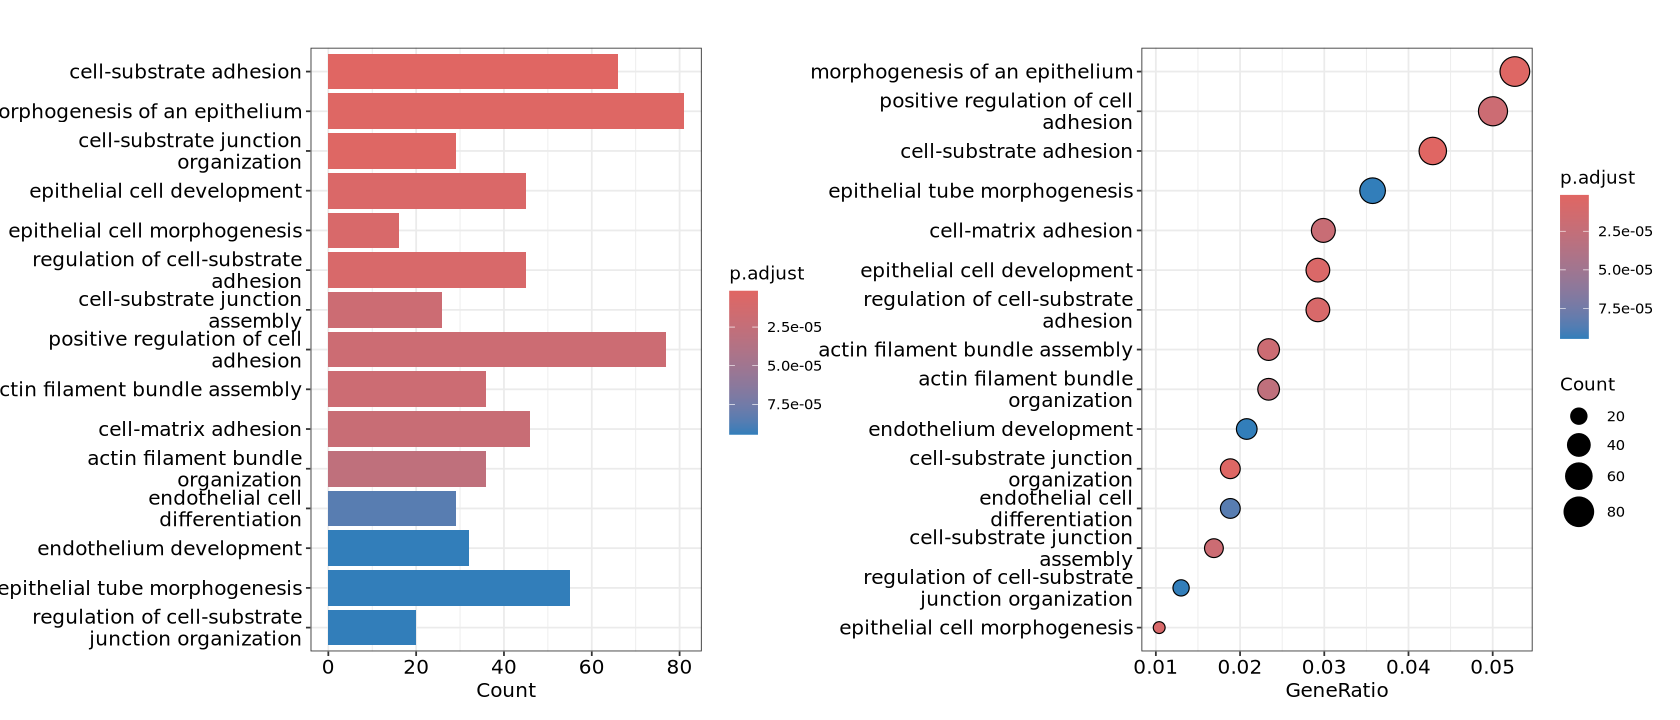

In [11]:
library(enrichplot)
options(repr.plot.width=14, repr.plot.height=6)
barplot(ego_diffPeak_cov, showCategory=15) + dotplot(ego_diffPeak_cov, showCategory=15)

**Enrichment map** organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets are tend to cluster together, making it easy to identify functional module.

The <code>emapplot</code> function supports results obtained from hypergeometric test and gene set enrichment analysis. The cex_category parameter can be used to resize nodes

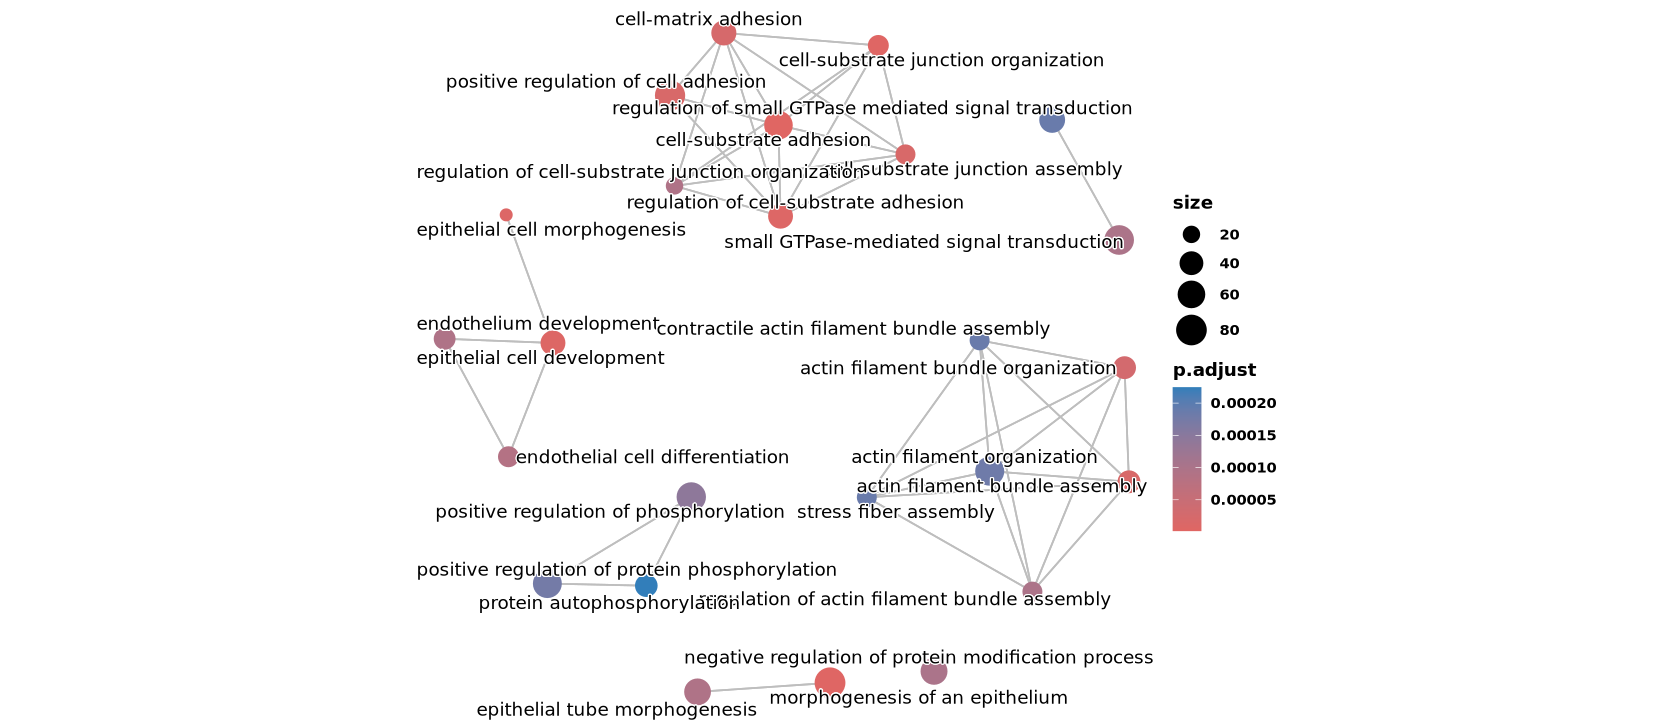

In [12]:
ego_diffPeak_cov <- pairwise_termsim(ego_diffPeak_cov)
emapplot(ego_diffPeak_cov,showCategory = 25)+theme(legend.text = element_text(face = "bold"),legend.title = element_text(face = "bold") )

### KEGG enrichment analysis
KEGG (Kyoto Encyclopedia of Genes and Genomes) is a collection of manually drawn pathway maps representing molecular interaction and reaction networks. These pathways cover a wide range of biochemical processes that can be divided into 7 broad categories:
* Metabolism
* Genetic information processing
* Environmental information processing
* Cellular processes
* Organismal systems
* Human diseases
* Drug development.

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



,category,subcategory,ID,Description,GeneRatio,BgRatio,RichFactor,FoldEnrichment,zScore,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04510,Cellular Processes,Cellular community - eukaryotes,hsa04510,Focal adhesion,41/769,203/8865,0.2019704,2.328307,5.900382,2.019087e-07,2.019087e-07,6.078513e-05,596/3655/1282/2316/7058/5906/5156/60/3480/4233/7422/3918/5159/1293/3678/4638/3693/7450/1399/2335/5728/3910/6696/1291/6093/5154/56034/5747/1284/6654/857/103910/55742/1499/3912/2317/9475/2932/394/5295/3915,41
hsa05215,Human Diseases,Cancer: specific types,hsa05215,Prostate cancer,21/769,98/8865,0.2142857,2.470277,4.510549,7.867710e-05,7.867710e-05,8.264937e-03,898/5970/596/1871/5156/2078/3480/2308/842/5159/6935/5728/5154/56034/6654/1499/7184/2932/5295/5327/1027,21
hsa04151,Environmental Information Processing,Signal transduction,hsa04151,PI3K-Akt signaling pathway,53/769,362/8865,0.1464088,1.687795,4.117845,9.288009e-05,9.288009e-05,8.264937e-03,898/3574/6194/5970/596/3655/1282/7058/117145/5156/3575/3480/3716/4233/2791/1435/7422/1969/3918/118788/1942/3164/842/5159/1293/3678/3693/7450/2066/2335/5728/1902/3910/6696/1291/5154/56034/5747/1284/6654/7531/3643/7099/3912/2309/7184/9223/2932/5295/3915/1027/4170/2782,53
hsa05222,Human Diseases,Cancer: specific types,hsa05222,Small cell lung cancer,20/769,93/8865,0.2150538,2.479131,4.419179,1.098138e-04,1.098138e-04,8.264937e-03,898/5970/596/317/3655/1282/1871/7185/3918/842/2335/5728/3910/5747/1284/3912/7188/5295/3915/1027,20
hsa05165,Human Diseases,Infectious disease: viral,hsa05165,Human papillomavirus infection,48/769,333/8865,0.1441441,1.661688,3.793085,2.873135e-04,2.873135e-04,1.166871e-02,898/54361/10474/1857/5970/3516/3655/1282/55534/57801/7058/9636/8323/5734/4600/3716/5584/7422/3918/2308/5159/1293/3678/3693/7450/2335/5728/8324/8325/3910/6696/1291/5747/1284/148022/6654/56288/3993/84441/9794/1499/3912/4599/9223/2932/5295/3915/1027,48
hsa03250,Genetic Information Processing,Information processing in viruses,hsa03250,Viral life cycle - HIV-1,15/769,64/8865,0.2343750,2.701865,4.211065,2.907647e-04,2.907647e-04,1.166871e-02,4131/29969/11052/4600/4130/9972/7852/1025/51497/4300/636/4298/5045/4599/5903,15


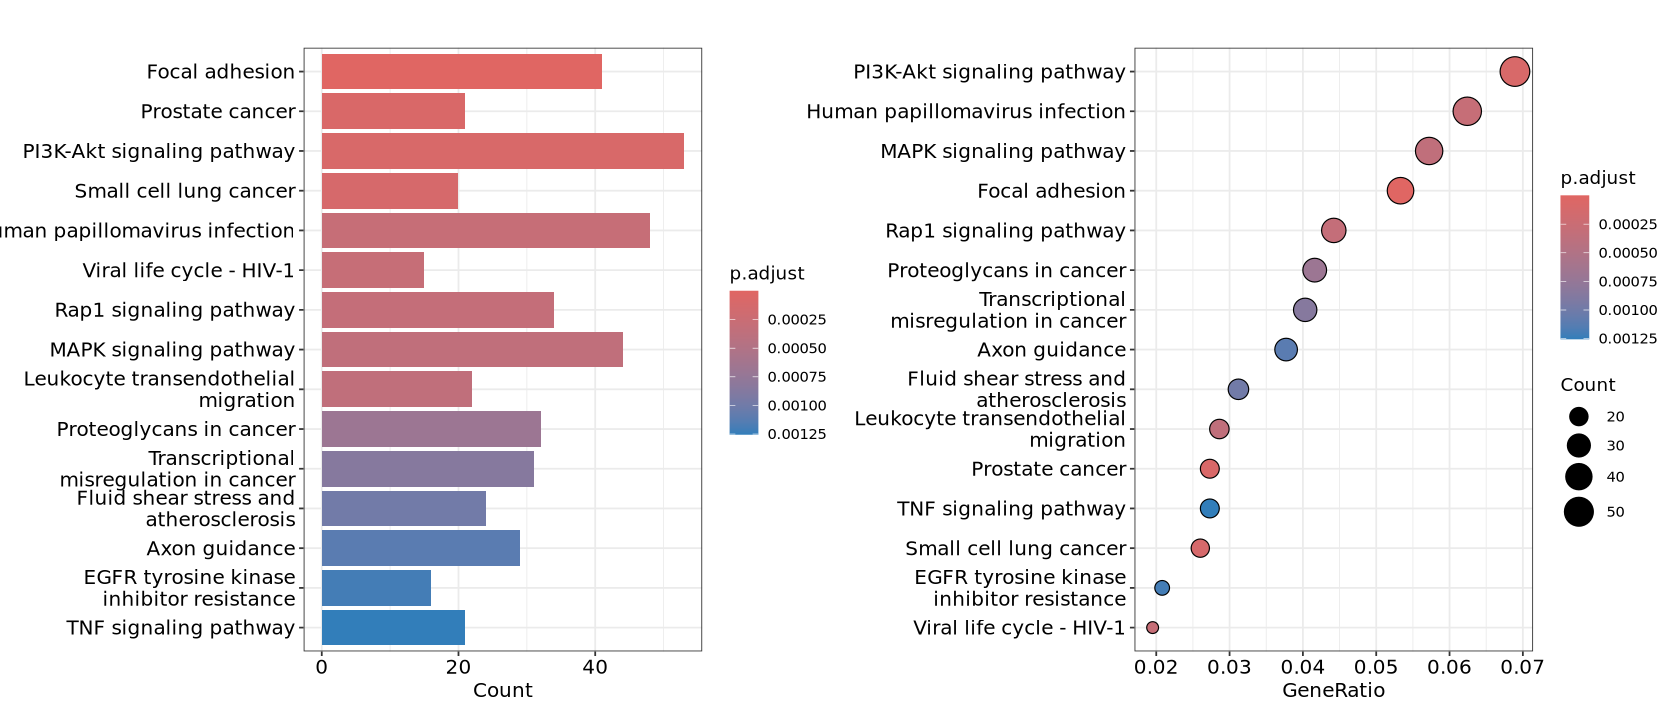

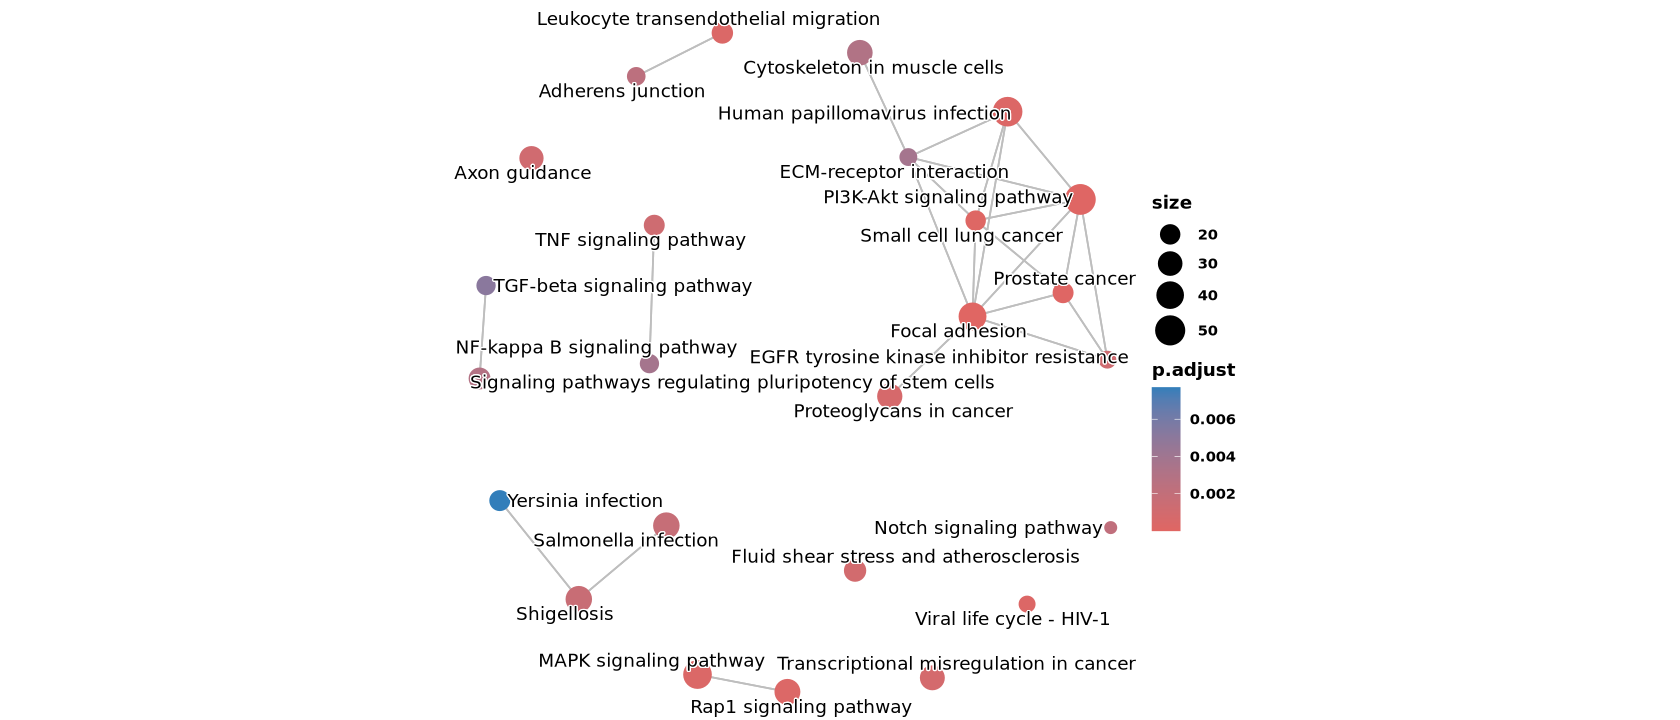

In [13]:
# KEGG pathway analysis
KEGG_diffPeak_cov <- enrichKEGG(eg_diffPeak_cov$ENTREZID,organism = "hsa",pAdjustMethod = "none", pvalueCutoff = 0.05,minGSSize = 3)
head(KEGG_diffPeak_cov)

# bar and dot plots
barplot(KEGG_diffPeak_cov, showCategory=15) + dotplot(KEGG_diffPeak_cov, showCategory=15)

# enrichment map
KEGG_diffPeak_cov <- pairwise_termsim(KEGG_diffPeak_cov)
emapplot(KEGG_diffPeak_cov,showCategory = 25)+theme(legend.text = element_text(face = "bold"),legend.title = element_text(face = "bold") )

## <b>4. Integration of RNA methylation and gene expression</b>

### 4.1 use Input samples to get the gene expression profile

In [14]:
# copy the data from s3 bucket to Tutorial_3 directory
system("aws s3 cp s3://ovarian-cancer-example-fastqs/submodule3/sample_info.txt .")

# load Sample information
samples <- data.frame(fread("sample_info.txt"),row.names=2)
samples <- subset(samples, Sample_description=="total RNA") # the other description is: m6A enriched RNA
samples$group <- factor(ifelse(grepl("normal",samples$Group), "normal", "tumor"))
samples

,Sample_title,Sample_source_name_ch1,Sample_organism_ch1,Group,Age,Sample_description,group
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>
GSM3359924,2380 input,ovary,Homo sapiens,omental tumor,62,total RNA,tumor
GSM3359925,2343 input,ovary,Homo sapiens,omental tumor,68,total RNA,tumor
GSM3359926,2270 input,ovary,Homo sapiens,omental tumor,70,total RNA,tumor
GSM3359927,2261 input,ovary,Homo sapiens,omental tumor,64,total RNA,tumor
GSM3359928,2221 input,ovary,Homo sapiens,omental tumor,68,total RNA,tumor
GSM3359929,2186 input,ovary,Homo sapiens,omental tumor,73,total RNA,tumor
GSM3359930,2064 input,ovary,Homo sapiens,normal Fallopian tube,36,total RNA,normal
GSM3359931,2013 input,ovary,Homo sapiens,normal Fallopian tube,59,total RNA,normal
GSM3359932,2053 input,ovary,Homo sapiens,normal Fallopian tube,35,total RNA,normal


In [15]:
# load input gene count matrix
read_counts <- fread("GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz")
read_counts <- data.frame(read_counts,row.names=1)
dim(read_counts)

# Keep the input samples only
cts <- read_counts[,rownames(samples)]
dim(cts)

[1] 39376    26

[1] 39376    13

### 4.2 DESeq2 differential gene expression analysis

In [ ]:
library(DESeq2)

#Create the DEseq2DataSet object
dds <- DESeqDataSetFromMatrix(countData = cts, colData = samples, design= ~ Age + group)

# Perform pre-filtering of the data
dds <- dds[rowSums(counts(dds)) > 10, ]

# Run pipeline for differential expression steps
dds <- DESeq(dds)
resultsNames(dds) # lists the coefficients

# show results of contrast comparisons
res <- results(dds, contrast = c("group", "tumor", "normal"))
summary(res)

**Volcano plot** of the differential expressed genes

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(rownames(res), fromType = "ENTREZID", toType = "SYMBOL", :
“4.39% of input gene IDs are fail to map...”
Warning message:
“ggrepel: 271 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


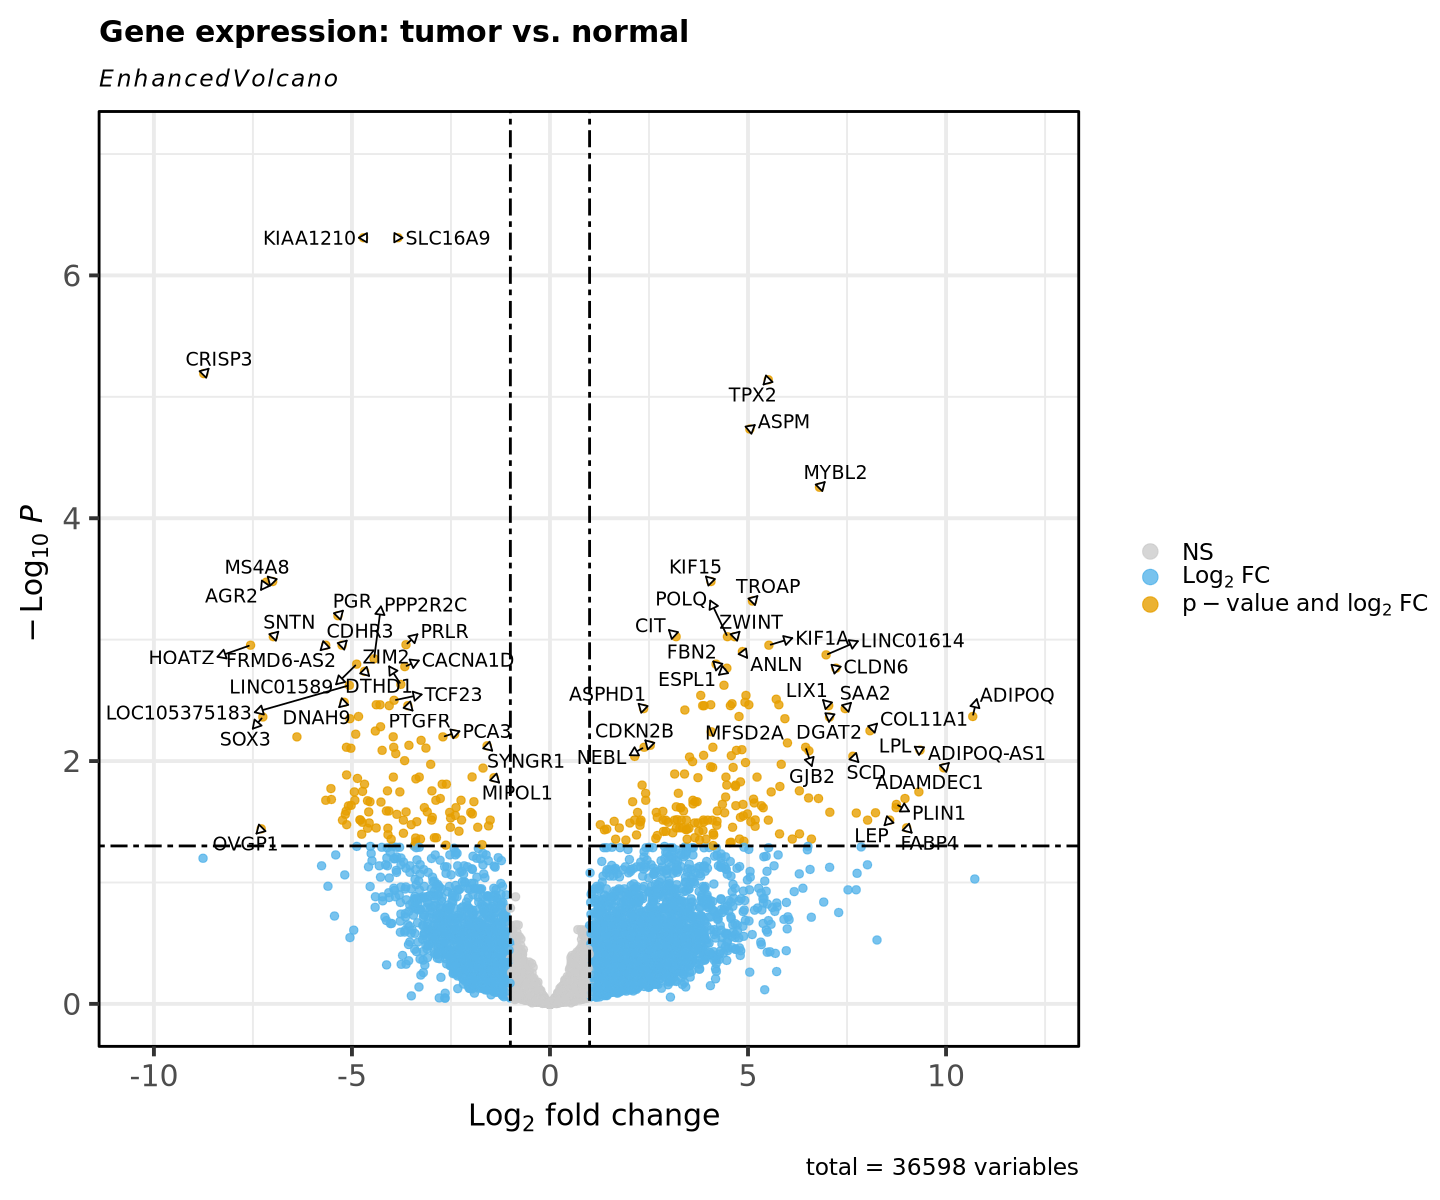

In [17]:
# annotate GENEID to gene symbol
library("clusterProfiler")
library("org.Hs.eg.db")
res_symbol <- bitr(rownames(res), fromType="ENTREZID", toType="SYMBOL", OrgDb="org.Hs.eg.db")
res_symbol <- data.frame(res_symbol,row.names=1)

# visualization of the Deseq2 restuls
library("EnhancedVolcano")

options(repr.plot.width=12, repr.plot.height=10)
EnhancedVolcano(res,
                lab = res_symbol[rownames(res),],
                title = 'Gene expression: tumor vs. normal',
                x = 'log2FoldChange',
                y = 'padj',
                ylim=c(0,7),
                pCutoff = 0.05,
                xlab = bquote(~Log[2]~ 'fold change'),
                cutoffLineType = 'twodash',
                cutoffLineWidth = 0.8,
                pointSize = 2,
                col = c('#cccccc', '#56B4E9', '#999999', '#E69F00'),
                colAlpha = 4/5,
                labSize = 4,
                legendPosition = 'right',
                legendLabSize = 14,
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.5,
                colConnectors = 'black',
                border = "full")

### 4.3 Integration of gene expression and RNA methylation differential results

In [18]:
# gene expression results
res <- results(dds, contrast = c("group", "tumor", "normal"))
de <- as.data.frame(res)
de$gene <- res_symbol[rownames(de),]
de <- de[!is.na(de$gene) & de$pvalue<0.05 & abs(de$log2FoldChange)>1,]
dim(de)

# RNA methylation results 
dmr <- Diff_peaks_cov[,c("name","logFC","p_value")]
dim(dmr)

# join two results 
combined <- merge(x=de, y=dmr, by.x="gene",by.y="name")
dim(combined)
head(combined)

[1] 3166    7

[1] 2245    3

[1] 263   9

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,logFC,p_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACSL1,1064.7139,3.884523,1.2980488,2.992586,0.002766244,0.1115460,-1.2952591,4.335496e-08
2,ADAMTS9,1661.7999,3.162662,1.1541671,2.740211,0.006139971,0.1628395,1.5333349,9.979239e-05
3,ALDH1A2,823.5306,-3.063792,1.0971289,-2.792554,0.005229368,0.1503545,-2.1936290,1.590757e-03
4,ALDOA,1234.7914,1.064524,0.3620451,2.940307,0.003278869,0.1191619,-1.2815377,2.454821e-08
5,ANKRA2,202.2685,-1.324293,0.6137371,-2.157753,0.030947037,0.3411022,-0.6577681,6.192223e-04
6,ANKRD9,112.3702,1.403848,0.6300909,2.228009,0.025879883,0.3125598,-0.9169961,1.623330e-03



 A  B  C  D 
32 11  9 22 

Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


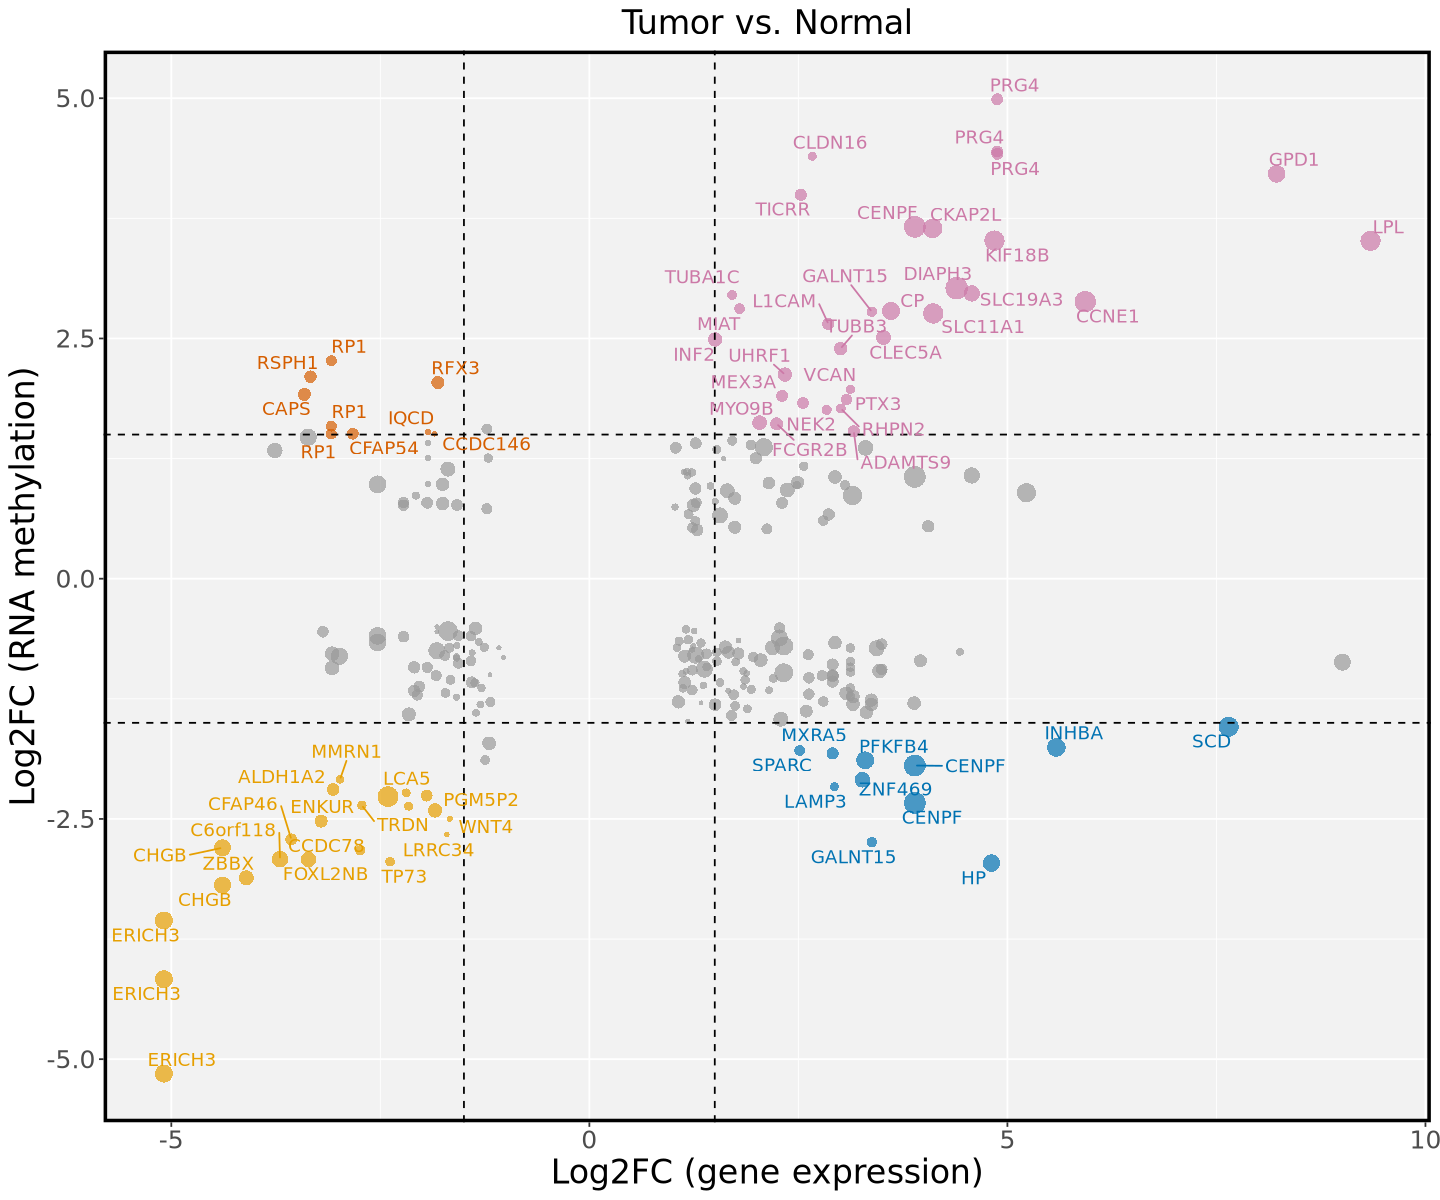

In [19]:
# integration volcano plot
library(ggplot2)
fc_cutoff <- 1.5
df <- combined
df$class[df$log2FoldChange >= fc_cutoff & df$logFC >= fc_cutoff]  <- "A"
df$class[df$log2FoldChange >= fc_cutoff & df$logFC <= -fc_cutoff]  <- "B"
df$class[df$log2FoldChange <= -fc_cutoff & df$logFC >= fc_cutoff]  <- "C"
df$class[df$log2FoldChange <= -fc_cutoff & df$logFC <= -fc_cutoff]  <- "D"
table(df$class)
df[is.na(df$class),"class"] <-  "E"
df$label <- ifelse(df$class=="E", "", df$gene)

cols <- c("#CC79A7", "#0072B2", "#D55E00", "#E69F00", "#999999")
ggplot(df, aes(x=log2FoldChange, y=logFC, color=class)) + 
    geom_point(aes(size=-log10(padj)),shape = 16,  show.legend = FALSE, alpha = .7) + #size = 2.5,
    scale_color_manual(values = cols) + 
    geom_vline(xintercept = c(-fc_cutoff, fc_cutoff),linetype="dashed") + 
    geom_hline(yintercept = c(-fc_cutoff, fc_cutoff),linetype="dashed") +
    geom_text_repel(aes(label=label)) +
    labs(x= "Log2FC (gene expression)", y="Log2FC (RNA methylation)",title="Tumor vs. Normal") +
    theme(legend.position="none",
          panel.background=element_rect(fill="grey95"),
          panel.border = element_rect(color = "black",fill = NA,linewidth = 2),
          plot.title = element_text(size=20,hjust=0.5),
          axis.text = element_text(size=15),
          axis.title = element_text(size=20)) 

## Conclusion
Provide an overview of the lessons and skills learned from the module.

## Clean up
A reminder to shutdown VM and delete any relevant resources. <br><br>